In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

# Dataset definition
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filename = self.files[idx]
        filepath = os.path.join(self.data_dir, filename)
        data = np.loadtxt(filepath)
        inputs = data[:16]
        target = data[17]
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# MLP model definition
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)

        self.fc_end = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        x = self.fc_end(x)
        return x

In [9]:


# Main function
if __name__ == "__main__":

    data_dir = "data_mixed_16/all"
    dataset = CustomDataset(data_dir)
    device = torch.device("cuda:3")
    
    # Split dataset into training and validation sets (4:1 ratio)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    batch_size = 64  # You can experiment with 128, 256, etc.
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Model, loss function, optimizer
    model = MLP().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # TensorBoard writer
    writer = SummaryWriter(log_dir='run_regression/mpl_1
    .6_6_batch64_lr0.0001')
    
    # Training loop
    num_epochs = 400  # Reduced for demonstration purposes
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        
        # Log training loss to TensorBoard
        writer.add_scalar('Training Loss', avg_train_loss, epoch)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
        
        # Calculate average validation loss for this epoch
        avg_val_loss = val_loss / len(val_loader)
        
        # Log validation loss to TensorBoard
        writer.add_scalar('Validation Loss', avg_val_loss, epoch)
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_16_model.pth')
        
        # Print average loss for this epoch
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
    
    # Close the writer
    writer.close()


Epoch [1/400], Train Loss: 0.002007075845706277, Val Loss: 0.0005596339535793831
Epoch [11/400], Train Loss: 0.00015001414618745913, Val Loss: 0.000170386735668455
Epoch [21/400], Train Loss: 8.880055389017798e-05, Val Loss: 0.00013667690004099357
Epoch [31/400], Train Loss: 6.079694926302182e-05, Val Loss: 0.00010709690920634421
Epoch [41/400], Train Loss: 4.594865177932661e-05, Val Loss: 0.00010149498424240233
Epoch [51/400], Train Loss: 3.60333178032306e-05, Val Loss: 9.230978960545508e-05
Epoch [61/400], Train Loss: 2.962867966052727e-05, Val Loss: 8.634268500298758e-05
Epoch [71/400], Train Loss: 2.5552610013255616e-05, Val Loss: 8.255446069312621e-05
Epoch [81/400], Train Loss: 2.1890270969015545e-05, Val Loss: 8.405574917327984e-05
Epoch [91/400], Train Loss: 1.8834035699546803e-05, Val Loss: 7.92521615147244e-05
Epoch [101/400], Train Loss: 1.7392904106964125e-05, Val Loss: 7.725601588640311e-05
Epoch [111/400], Train Loss: 1.61117411320447e-05, Val Loss: 7.577066700699138e-05


In [6]:
# Load and evaluate the best saved model (for testing)
device = torch.device("cuda:3")
model = MLP().to(device)
model.load_state_dict(torch.load('best_16_model.pth'))


<All keys matched successfully>

In [7]:
import numpy as np
import os
from tqdm import tqdm

I2 = []
I2_pred = []

data_dir = 'data_mixed_16/I2'
files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]

for f in tqdm(files):
    I2.append(np.loadtxt(data_dir + '/' + f))

data_dir = 'data_mixed_16/all'
files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]

for f in tqdm(files):
    custom_data = np.loadtxt(data_dir + '/' + f)
    custom_data_tensor = torch.tensor(custom_data[:16], dtype=torch.float).to(device)
    model.eval()
    with torch.no_grad():
        custom_output = model(custom_data_tensor)
    I2_pred.append(custom_output.item())

100%|██████████| 100000/100000 [01:00<00:00, 1650.23it/s]


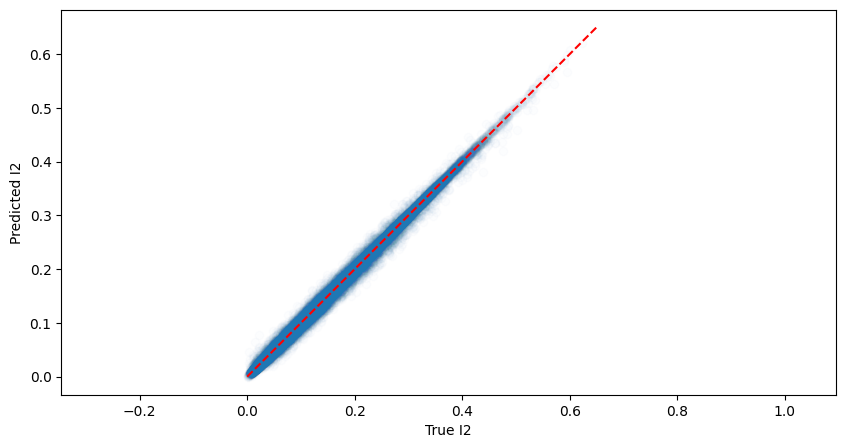

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(I2, I2_pred, 'o',alpha=0.01)
plt.plot([0, 0.65], [0, 0.65], 'r--')
plt.xlabel('True I2')
plt.ylabel('Predicted I2')
plt.axis('equal')
plt.xlim(0, 0.75)

plt.savefig('I2_pred_16.png', dpi=300, bbox_inches='tight')